In [157]:
import numpy as np
from keras.datasets import mnist
from scipy.signal import correlate2d
from layer import Layer

In [158]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [159]:
x_train.shape


(60000, 28, 28)

In [160]:
limit=2000
x_train=x_train[:limit]
y_train=y_train[:limit]
x_test=x_test[:limit]
y_test=y_test[:limit]


In [161]:
x_train.shape

(2000, 28, 28)

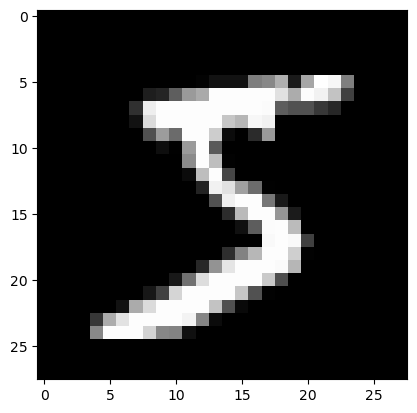

In [162]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap='gray')


In [168]:
class Convolutional_layer(Layer):
    def __init__(self,input_shape, num_filters, filter_size):

        input_depth, input_height, input_width = input_shape
        self.num_filters=num_filters
        self.filter_size=filter_size
        self.input_depth=input_depth
        self.input_height=input_height
        self.input_width=input_width
        
        self.filters=np.random.randn(num_filters,input_depth, filter_size, filter_size)
        self.output_shape = (num_filters, input_height - filter_size + 1, input_width - filter_size + 1)
        self.biases=np.random.randn(self.output_shape[0],self.output_shape[1],self.output_shape[2])
        
    def forward(self, input):
        print(self.filters.shape)
        self.input=input        
        print(self.input.shape)
        self.output=np.zeros((self.input_depth,self.num_filters, self.input_height - self.filter_size + 1, self.input_width - self.filter_size + 1))
        self.output+=self.biases
        
        for i in range(self.num_filters):
            for j in range(self.input_depth):
                self.output[j]+=correlate2d(self.input[j],self.filters[i,j],'valid')
                
        return self.output
    
    def backward(self, output_grad, lr):
        dL_dfilters=np.zeros(self.filters.shape)
        dL_dinput=np.zeros(self.input.shape)
        dL_dbiases=np.zeros(self.biases.shape)
        for i in range(self.num_filters):
            for j in range(self.input_depth):
                dL_dfilters[i,j]=correlate2d(self.input[j],output_grad[i],'valid')
                dL_dinput[j]+=correlate2d(output_grad[i],self.filters[i,j],'full')
        self.filters-=lr*dL_dfilters
        self.biases-=lr*output_grad
        return dL_dinput
        
        
        

In [172]:
class MaxPooling_Layer(Layer):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def forward(self, input):
        self.input = input
        
        self.output = np.zeros((self.input_shape[0], self.input_shape[1], self.input_shape[2]//2, self.input_shape[3]//2))
        
        for i in range(self.input_shape[0]):
          for n in range(0, self.input_shape[1]):
            for j in range(0, self.input_shape[2], 2):
                for k in range(0, self.input_shape[3], 2):
                    self.output[ i , n , j//2,k//2] = np.max(self.input[i, n ,j:j+2,k:k+2])
                    
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

    

In [183]:
output_conv=Convolutional_layer(x_train.shape, 5, 3).forward(x_train)

(5, 2000, 3, 3)
(2000, 28, 28)


In [184]:
output_conv.shape

(2000, 5, 26, 26)

In [ ]:
class reLU(Layer):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def forward(self, input):
        self.input = input
        self.output = np.maximum(0, input)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        return output_gradient * (self.input > 0)

In [182]:
from dense import Dense
from reshape import Reshape
from activations import Softmax

In [147]:

network = [
    Convolutional_layer(x_train.shape, 3, 3),
    reLU((2000, 5, 26, 26)),
    MaxPooling_Layer((2000, 5, 26, 26)),
    Reshape((2000, 5, 13, 13),(2000, 845)),
    
    Dense()
    Softmax()
]


(5, 2000, 3, 3)


In [148]:
output.shape

(5, 26, 26)

In [149]:
backprop=C_layer.backprop(output,0.01)

In [151]:
backprop.shape

(2000, 28, 28)

In [138]:
class MaxPooling_Layer():
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def forward(self, input):
        self.input = input
        self.output = np.zeros((self.input_shape[0], self.input_shape[1]//2, self.input_shape[2]//2))
        
        for i in range(self.input_shape[0]):
            for j in range(0, self.input_shape[1], 2):
                for k in range(0, self.input_shape[2], 2):
                    self.output[i,j//2,k//2] = np.max(self.input[i,j:j+2,k:k+2])
                    
        return self.output
    
    def backprop(self, dL_dout):
        dL_dinput = np.zeros(self.input.shape)
        
        for i in range(self.input_shape[0]):
            for j in range(self.input_shape[1]//2):
                for k in range(self.input_shape[2]//2):
                    a = self.input[i,j*2:j*2+2,k*2:k*2+2]
                    b = np.zeros((2,2))
                    (l,m) = np.unravel_index(np.argmax(a), a.shape)

In [139]:
C_layer=Convolutional_layer(x_train,x_train.shape,5,3)
result=C_layer.forward()

TypeError: Convolutional_layer.__init__() takes 4 positional arguments but 5 were given

In [ ]:
C_layer.backprop(result,0.01)

ValueError: operands could not be broadcast together with shapes (3,3) (28,28) (3,3) 

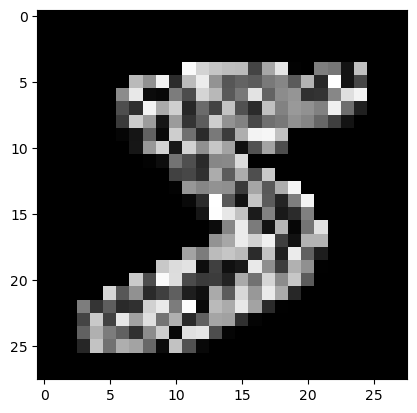

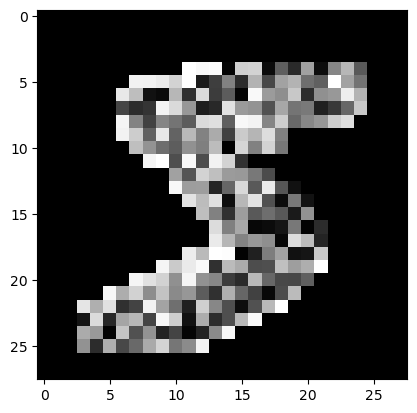

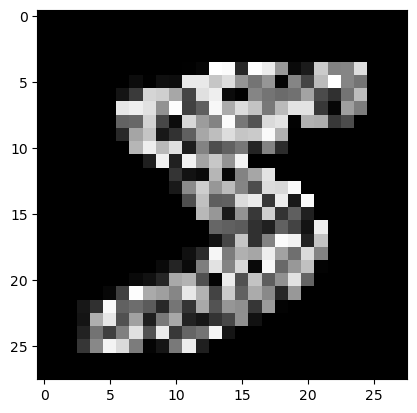

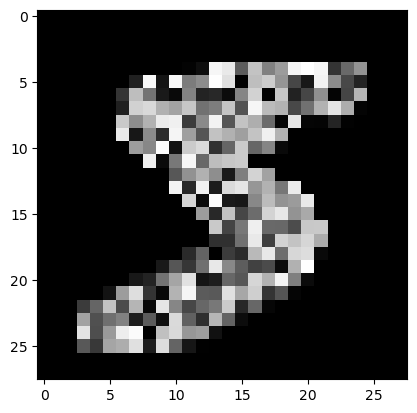

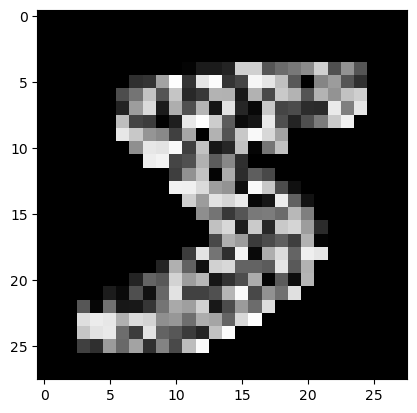

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(result[i], cmap='gray')
    plt.show()

In [ ]:
one_ex=x_train[0]

In [ ]:
one_ex.shape
conv_filters = np.random.randn(5, 3, 3)

In [ ]:
print(conv_filters[0])

[[-0.48921245  0.35935523  0.14146524]
 [-0.00479226 -0.19620189  0.04810729]
 [ 1.07119064  2.40783704  0.03018003]]


In [ ]:
for i in range(5):
    print(one_ex.shape)
    print(conv_filters[i].shape)
    result=convolve(one_ex, conv_filters[i])

(28, 28)
(3, 3)
(28, 28)
(3, 3)
(28, 28)
(3, 3)
(28, 28)
(3, 3)
(28, 28)
(3, 3)


In [ ]:
result

(28, 28)